Importiere alle notwendigen Bibliotheken:

In [245]:
import mne
import pickle
import numpy as np
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from functions import load_np_array_pickle
from tensorflow.keras.models import load_model
import scipy as sp
import time
from multiprocessing import Pool, cpu_count
from sklearn.cluster import KMeans
import sys
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.signal import find_peaks
import random
from collections import defaultdict

Um Artefakte wie EOG-Artefakte herauszufiltern, muss die Elektrodenplatzierung bekannt sein. Hier liegt das Standard 1005 Layout vor. Die Elektroden werden nach dem internationalen System 10-05 benannt und positioniert

Extracting parameters from ../files/eeg_files/Control1415.vhdr...
Setting channel info structure...
Reading 0 ... 810059  =      0.000 ...  1620.118 secs...


/var/folders/37/wjbnvn9s3gvb2cmxzyy0d_880000gn/T/ipykernel_2475/1471454838.py:2: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision('../files/eeg_files/' + filename, preload=True)
/var/folders/37/wjbnvn9s3gvb2cmxzyy0d_880000gn/T/ipykernel_2475/1471454838.py:2: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision('../files/eeg_files/' + filename, preload=True)
/var/folders/37/wjbnvn9s3gvb2cmxzyy0d_880000gn/T/ipykernel_2475/1471454838.py:2: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['Resp']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision('../files/eeg_files/' + filename, preload=True)


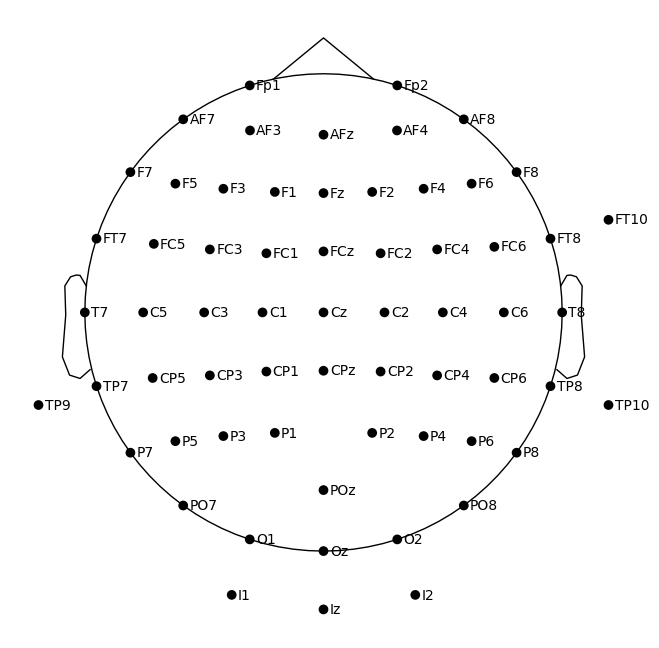

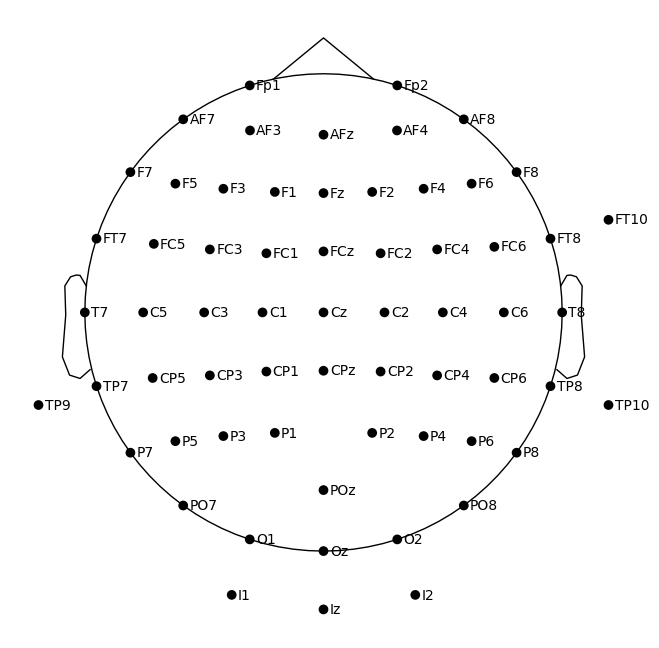

In [246]:
filename = 'Control1415.vhdr'
raw = mne.io.read_raw_brainvision('../files/eeg_files/' + filename, preload=True)

raw.plot_sensors(show_names=True)

#### Signalverarbeitung

Im ersten Schritt wird eine Hoch- und Tiefpass Filterung, sowie der Notchfilter angewendet

In der Regel ist es empfehlenswert, zuerst Hoch- und Tiefpassfilterungen anzuwenden, bevor man die ICA (unabhängige Komponentenanalyse) durchführt. Der Grund dafür ist, dass die Filterung unerwünschte Frequenzbereiche entfernt und somit die Qualität der ICA-Ergebnisse verbessert. Hoch- und Tiefpassfilter helfen, Rauschen und Artefakte aus den EEG-Daten zu entfernen, die aufgrund von Muskelbewegungen, Augenbewegungen oder anderen externen Störungen entstehen können.

Eine Quelle, die diesen Ansatz unterstützt, ist die folgende:

Delorme, A., & Makeig, S. (2004). EEGLAB: an open source toolbox for analysis of single-trial EEG dynamics including independent component analysis. Journal of neuroscience methods, 134(1), 9-21.

In diesem Artikel präsentieren die Autoren EEGLAB, eine Open-Source-Toolbox zur Analyse von EEG-Daten. Sie empfehlen, zuerst eine Filterung durchzuführen, um das Signal-Rausch-Verhältnis zu verbessern, bevor man die ICA anwendet.

In [247]:
lowpass = 0.5
highpass = 30

# Notch Frequenzen
notch_frequencies = [50, 60]

filtered_raw = raw.copy()

# Anwendung des Notch-Filters
filtered_raw.notch_filter(notch_frequencies)

l_freq = float(lowpass)
h_freq = float(highpass)
# Definieren Sie die Filtergrenzen
l_freq = float(l_freq)
h_freq = float(h_freq)
# Anwenden des Butterworth-Filters
filtered_raw.filter(l_freq, h_freq, fir_design='firwin')






Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


<RawBrainVision | Control1415.eeg, 64 x 810060 (1620.1 s), ~395.6 MB, data loaded>

In [248]:
test = raw.copy()

In [249]:

test.filter(0.1, 30, fir_design='firwin')
plt.plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.9s finished


[]

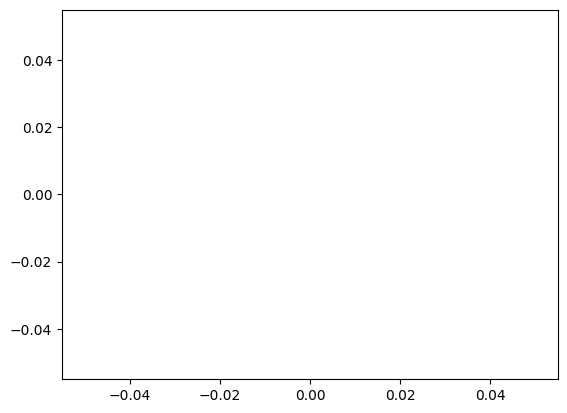

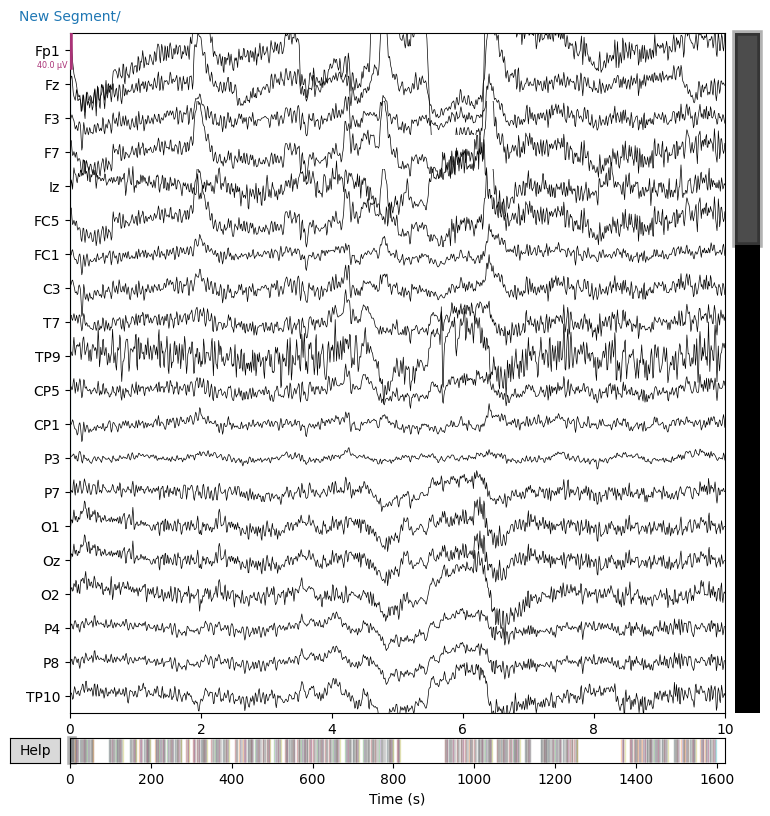

In [250]:
filtered_raw.plot()
plt.show()

#### ICA

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 50 components
Fitting ICA took 52.6s.


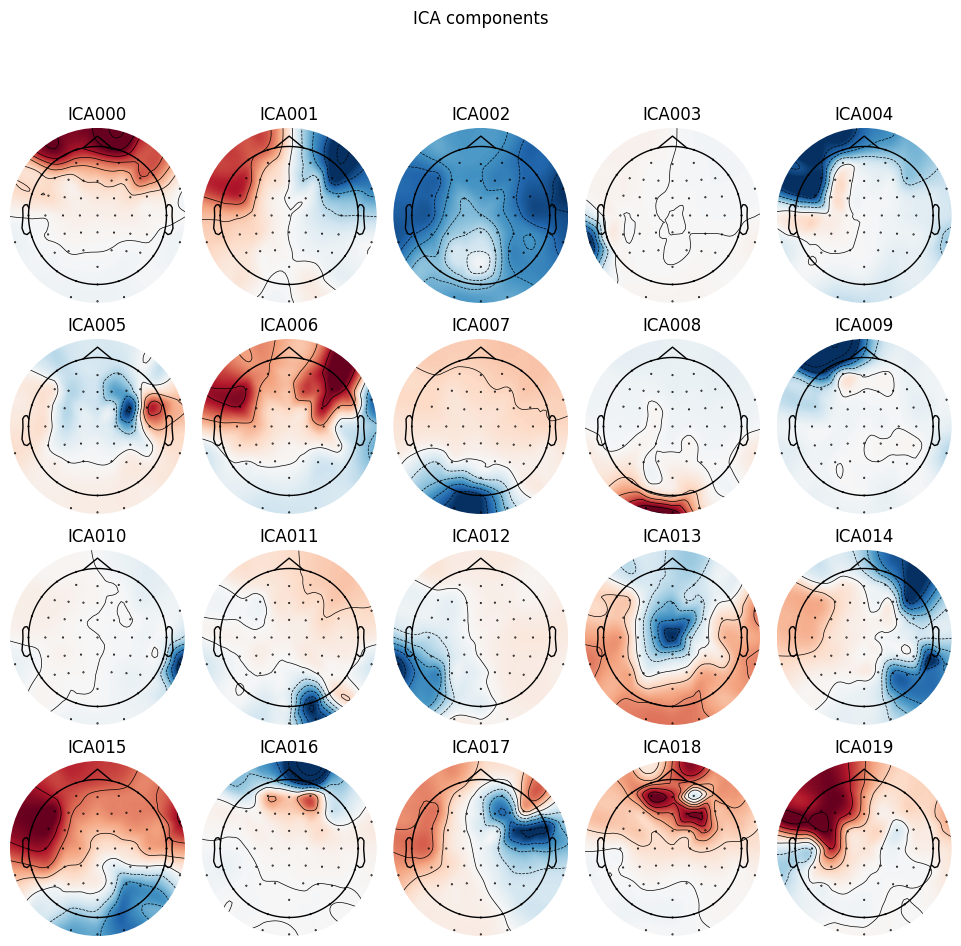

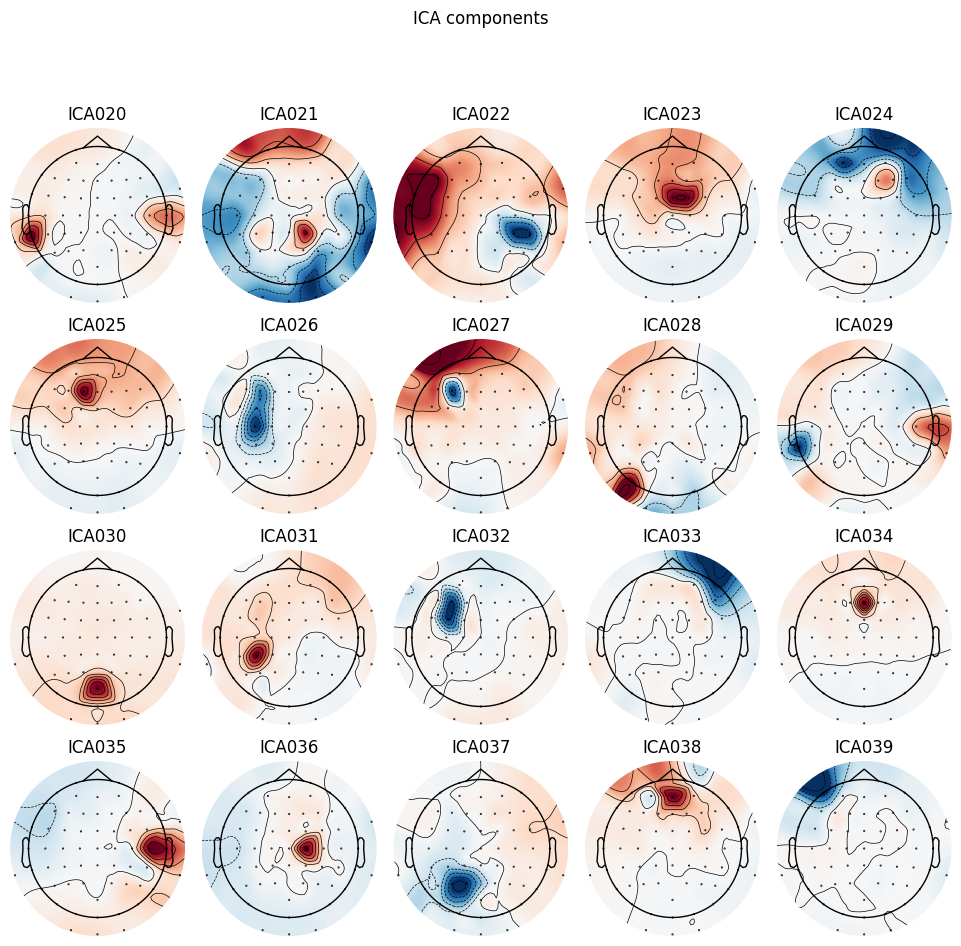

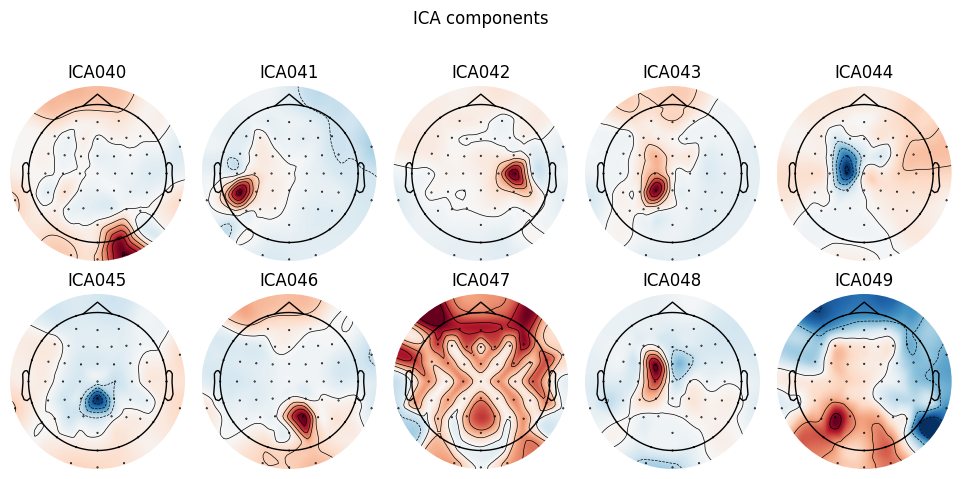

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x496 with 10 Axes>]

In [251]:
# Wenden Sie die ICA auf die gefilterten Daten an
n_components = None  # None für Auswahl von allen Komponenten

method = 'fastica'  
random_state = 42  

# ICA-Objekt erstellen
ica = ICA(n_components=50, method=method, random_state=random_state)

# ICA an die Rohdaten anpassen
ica.fit(filtered_raw)

# ICA-Komponenten visualisieren (optional)
ica.plot_components()

In solchen ICA-Komponenten-Topoplots ist es wichtig, auf Muster zu achten, die Artefakte wie EOG, EKG und Muskelaktivität anzeigen könnten. Bei der Analyse solcher Plots sollten Sie nach folgenden Mustern suchen:

EOG-Artefakte: Konzentrierte Aktivität um die frontopolaren Elektroden (in der Nähe der Augen). Bei den gezeigten Komponenten scheint es, als ob Komponente 1 ein potenzielles EOG-Artefakt sein könnte, da sie Aktivität in der frontopolaren Region zeigt.
EKG-Artefakte: Konzentrierte Aktivität um die Schläfen oder die Nackenelektroden, die auf Aktivität des Herzens zurückzuführen sein könnte. Auf den ersten Blick scheint es keine offensichtlichen EKG-Artefakte in den gezeigten Komponenten zu geben.
Muskelartefakte: Lokalisierte Aktivität in bestimmten Kopfbereichen, insbesondere an den Schläfen oder in der Nähe der Kaumuskulatur. Es ist schwierig, definitiv zu sagen, ob es Muskelartefakte in den gezeigten Komponenten gibt, da die Identifizierung solcher Artefakte oft schwieriger ist. Sie könnten jedoch einige der Komponenten genauer untersuchen, die lokalisierte Aktivität in bestimmten Bereichen aufweisen (z. B. Komponenten 6, 9 oder 18), um festzustellen, ob sie möglicherweise Muskelartefakte repräsentieren.



##### Herausfilterung von EOG-Artefakten

Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [ 0 30]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 200 significant peaks
Number of EOG events detected: 200
Not setting metadata
200 matching events found
No baseline correction applied
Using data from preloaded Raw for 200 events and 501 original time points ...
0 bad epochs dropped
Using EOG channels: Fp1, Fp2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


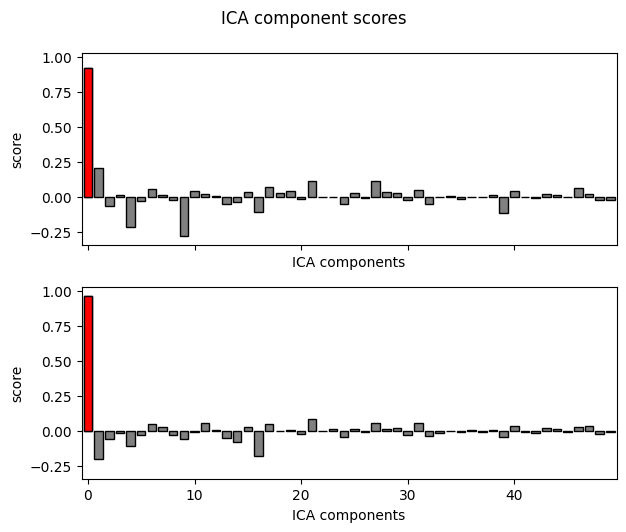

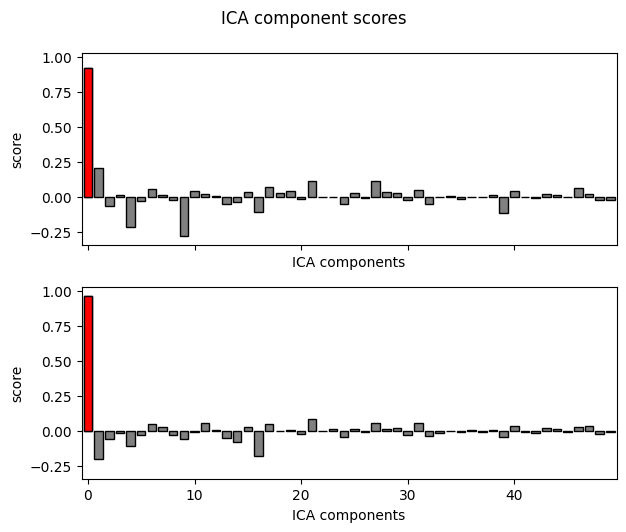

In [252]:
raw_clean = filtered_raw.copy()
eog_epochs = mne.preprocessing.create_eog_epochs(raw_clean, ch_name=['Fp1', 'Fp2'])
eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name=['Fp1', 'Fp2'])
ica.plot_scores(eog_scores, eog_inds)

Using threshold: 0.23 for CTPS ECG detection
Using channel Iz to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 5000 samples (10.000 sec)

Number of ECG events detected : 2318 (average pulse 85 / min.)
Not setting metadata
2318 matching events found
No baseline correction applied
Using data from preloaded Raw for 2318 events and 501 original time points ...
1 bad epochs dropped


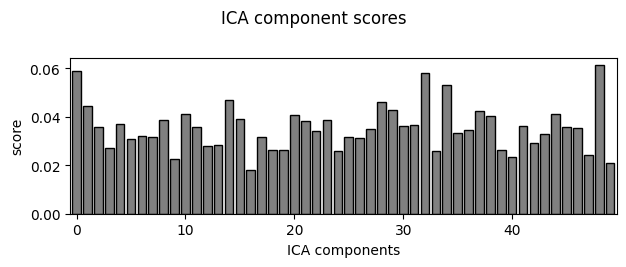

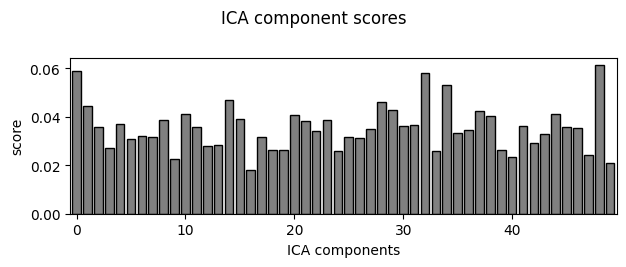

In [253]:
# Markieren Sie den EKG-Kanal in den Rohdaten (falls noch nicht geschehen)
ecg_channel = 'Iz'  # Ersetzen Sie dies durch den tatsächlichen Namen Ihres EKG-Kanals
raw_clean.set_channel_types({ecg_channel: 'ecg'})

# Finden Sie die EKG-Artefakt-Komponenten
ecg_indices, ecg_scores = ica.find_bads_ecg(raw_clean)
ica.plot_scores(ecg_scores)

#### Ausgabe des ersten Kanals

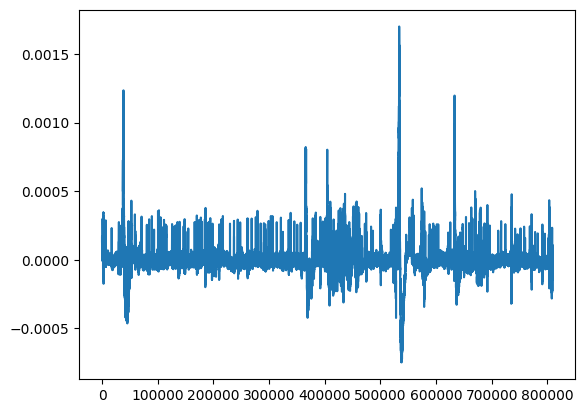

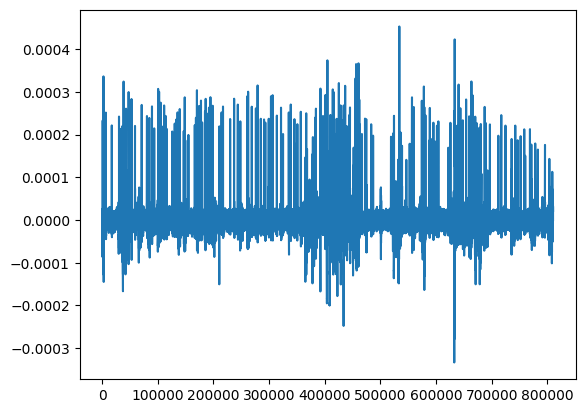

In [254]:
plt.plot(raw.get_data()[0])
plt.show()
plt.plot(filtered_raw.get_data()[0])
plt.show()

#### Methode 1

In dieser Methodik, werden die Signale der einzelnen Kanäle in kleinere Fenster unterteit, sodass sie auf Peaks untersucht werden können. 

|| Anpassen der Überlappung und der Fenstergröße ||

In [255]:
def create_windows(overlap_val, window_size, raw_data, sample_rate):
    window_size = int(window_size)
    average_overlap = float(overlap_val)
    step_size = int(window_size * (1 - average_overlap))  # Berechne die Schrittgröße
    windows_set = []
    
    for data in raw_data:
        windows = []
        for i in range(0, len(data) - window_size + 1, step_size):
            start_time = i / sample_rate
            end_time = (i + window_size) / sample_rate
            time_range = (start_time, end_time)
            windows.append({'time': time_range, 'data': data[i:i + window_size]})
        windows_set.append(windows)

    return windows_set

windows = create_windows(0.666666, 300, raw_clean.get_data()[:-1], 500)
print(len(windows), len(windows[0]))




63 8098


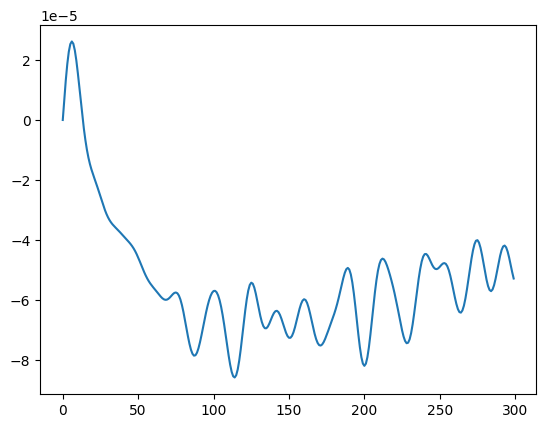

In [256]:
plt.plot(windows[0][0]['data'])
plt.show()

#### Dictionary erstellen

Um alle Fenster in einen Topf zu werfen, ohne Verlust von Informationen wie Kanal oder Zeitfenster, wird ein Dictionary erstellt

In [257]:
def create_window_dict(all_windows, raw):
    window_dict = []
    for idx, channel in enumerate(all_windows):
        for window in channel:
            window_dict.append({'channel': raw.ch_names[idx], 'nr': id, 'time': window['time'], 'data': window['data']})
    return window_dict

windows_dict = create_window_dict(windows, raw_clean)
print(len(windows_dict))

510174


Fenster Normalisieren, um Daten zwischen 0 und 1 zu skalieren
1. Extrahiere die Daten aus jedem Objekt in der Liste win.
2. Konvertiere die Daten in ein 1D-Array (data_array).
3. Berechne das Maximum (max_value) und das Minimum (min_value) der Daten.
4. Normalisiere jeden Datenwert in der Liste win durch Subtraktion des Mindestwerts und Division durch den Bereich (max_value - min_value).
5. Aktualisiere die Daten in der Liste win mit den normalisierten Werten.


In [258]:
def normalize_epochs(win):
    # Extrahieren der Daten aus jedem Objekt in der Liste
    data_list = [obj['data'] for obj in win]

    # Konvertieren der Daten in ein 1D-Array
    data_array = np.concatenate(data_list)

    # Berechnen des Maximums und Minimums der Daten
    max_value = np.max(data_array)
    min_value = np.min(data_array)

    for idx, data in enumerate(win):
        normalized_data = []
        for value in data['data']:
            normalized_value = (value - min_value) / (max_value - min_value)
            normalized_data.append(normalized_value)
        win[idx]['data'] = normalized_data
    return win

In [259]:
normalized_windows_dict = normalize_epochs(windows_dict)


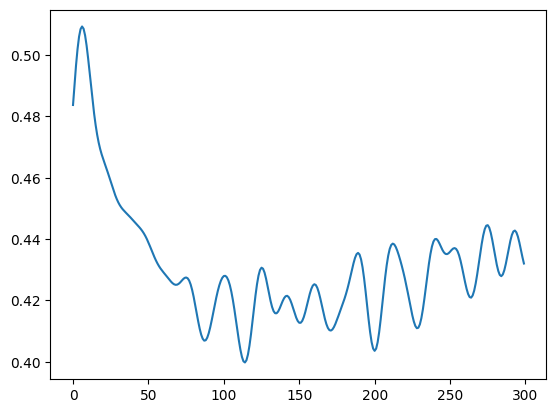

In [260]:
plt.plot(normalized_windows_dict[0]['data'])
plt.show()

Da im Signal viele Flatlines zu finden sind, werden diese mithilfe der Standardabweichung ermittelt und von den restlichen fenstern getrennt.

|| Threshold anpassen ||

In [261]:
def is_linear(data, threshold):
    std = np.std(data)
    if std > threshold:
        return True
    else:
        return False


def clear_flatlines(data, threshold1):
    windows = data
    
    # Entferne die Elemente, die nicht linear sind, in einer separaten Schleife
    to_delete1 = set()
    for idx1, window in enumerate(windows):
        if not is_linear(window['data'], threshold1):
            to_delete1.add(idx1)
    windows = np.delete(windows, list(to_delete1), axis=0)
    deleted_windows = [data[i] for i in to_delete1]
    
    return windows, deleted_windows


# Berechne Standardabweichungen für alle Fenster
std_values = [np.std(window['data']) for window in normalized_windows_dict]
# Finde das gewünschte Perzentil (z.B. 25. Perzentil) der Standardabweichungen
th = np.percentile(std_values, 95)

cleared_windows, deleted_windows = clear_flatlines(normalized_windows_dict, th)
print(len(cleared_windows), len(deleted_windows))

25509 484665


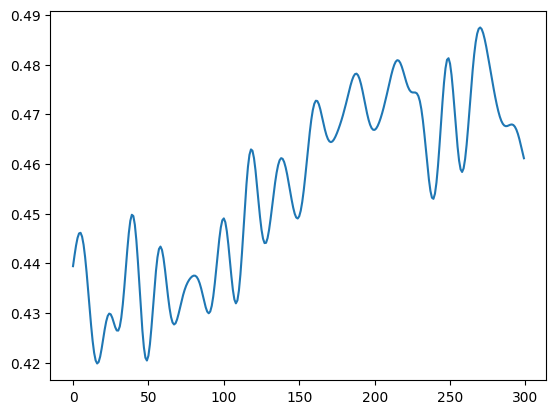

In [262]:
plt.plot(cleared_windows[567]['data'])
plt.show()

wie oben zu sehen ist, existieren fenster ohne jegliche Peaks, daher müssen auch solche fenster aussortiert werden:

1. Zwei Listen werden erstellt: final_windows und no_peaks.
2. Eine Funktion namens peak_above_threshold wird definiert, die die folgenden Parameter annimmt:
    - data: Eine Liste von Datenwerten.
    - threshold: Der Schwellenwert für die Amplitude, über dem ein Peak als gültig betrachtet wird.
    - edge_distance_percent: Ein Prozentsatz der Datenlänge, der den Mindestabstand von einem Peak zum Anfang oder Ende der Daten bestimmt.
    - peak_width_percent: Ein Prozentsatz der Datenlänge, der die maximale Breite des Peaks bestimmt.
3. Die Funktion peak_above_threshold führt die folgenden Schritte aus:
    - Berechnet edge_distance als den Mindestabstand von einem Peak zum Anfang oder Ende der Daten.
    - Berechnet peak_width als die maximale Breite des Peaks, falls peak_width_percent angegeben ist.
    - Verwendet die Funktion find_peaks aus SciPy, um die Peaks in den Daten und deren Eigenschaften zu finden. Hierbei werden threshold und peak_width als Filterkriterien verwendet.
    - Prüft, ob mindestens ein Peak in den Daten vorhanden ist, der die Bedingung edge_distance erfüllt. Gibt True zurück, wenn ein solcher Peak gefunden wird, andernfalls False.
4. Iteriert über die Liste cleared_windows und prüft für jedes Fenster, ob ein Peak oberhalb des Schwellenwerts vorhanden ist.
    - Wenn ein Peak oberhalb des Schwellenwerts gefunden wird, wird das Fenster zur Liste final_windows hinzugefügt.
    - Wenn kein Peak gefunden wird, wird das Fenster zur Liste no_peaks hinzugefügt.
5. Am Ende gibt der Code die Länge von final_windows und no_peaks aus, um die Anzahl der Fenster in jeder Liste zu zeigen.

In [263]:
final_windows = []
no_peaks = []

def peak_above_threshold(data, threshold, edge_distance_percent, peak_width_percent):
    edge_distance = int(len(data) * edge_distance_percent)
    if peak_width_percent is not None:
        peak_width = len(data) * peak_width_percent
    else:
        peak_width = None
    
    peaks, properties = find_peaks(data, height=threshold, width=peak_width)
    
    for peak in peaks:
        if edge_distance <= peak <= len(data) - edge_distance - 1:
            return True
    return False


for window in cleared_windows:
    if peak_above_threshold(window['data'], 0.55, 0.15, 0.2):
        final_windows.append(window)
    else:
        no_peaks.append(window)
        
print(len(final_windows), len(no_peaks))

3426 22083


Um eine Datenmenge an Flatlines und Rauschen zu erzeugen die im späteren Verlauf als Trainingsdaten verwendet werden sollen, werden diese zunächst hergerichtet

In [264]:
windows_flatlines = no_peaks + deleted_windows

def calculate_standard_deviation(data):
    return np.std(data)


def filter_del_windows(data_list, std_dev_range, width):
    # Berechne die Standardabweichungen für jede Datenreihe in der Liste
    std_devs = [calculate_standard_deviation(data['data']) for data in data_list]

    # Filtere die Datenreihen, deren Standardabweichung innerhalb des angegebenen Bereichs liegt
    filtered_data_list = [data for data, std_dev in zip(data_list, std_devs) if
                          std_dev_range[0] <= std_dev <= std_dev_range[1]]

    # Entferne Datenreihen, die einen breiten Peak (Glockenkurven-ähnlichen Verlauf) aufweisen
    filtered_data_list = [data for data in filtered_data_list if len(find_peaks(data['data'], width=width)[0]) == 0]

    return filtered_data_list

def filter_del_std(data_list, std_dev_threshold):
    # Berechne die Standardabweichungen für jede Datenreihe in der Liste
    std_devs = [calculate_standard_deviation(data['data']) for data in data_list]

    # Filtere die Datenreihen, deren Standardabweichung unter dem angegebenen Schwellenwert liegt
    filtered_data_list = [data for data, std_dev in zip(data_list, std_devs) if std_dev < std_dev_threshold]

    return filtered_data_list

    
filtered_del_windows = filter_del_windows(windows_flatlines, (0.03, 1.5), 25)
filtered_std_del = filter_del_std(windows_flatlines, 0.03)
del_windows = filtered_del_windows + random.sample(filtered_std_del, len(filtered_del_windows)) 
print(len(del_windows))

6338
3169


In [267]:
with open("../files/windows_files/final_windows.pickle", 'wb') as f:
    pickle.dump(final_windows, f)
with open("../files/windows_files/windows_flatlines.pickle", 'wb') as f:
    pickle.dump(del_windows, f)

#### Epochen Methode

Statt der Segmentierung und einer tiefen vorfilterung, werden annotierte Stimuli genutzt um Reaktionssignale innerhalb von EEG Signalen zu finden. Diese Stellen die Antwort der Hirnregion dar, dass auf diese Stimuli wirkt. Daher muss zunächst überprüft werden, ob es unterschiedliche Antwort-Signale im EEG auf die unterschiedlichen Stimuli gibt, bevor ein Neuronales Netz diese Signale finden kann. 

#### Erstellung der Epochen

Not setting metadata
870 matching events found
Setting baseline interval to [-0.3, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 870 events and 501 original time points ...
0 bad epochs dropped
(870, 64, 501)


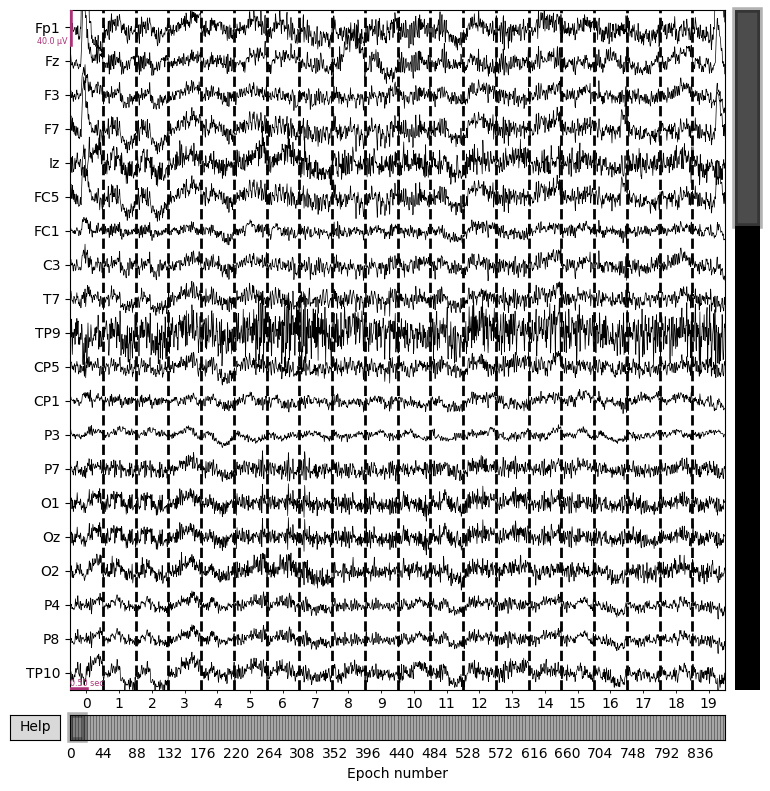

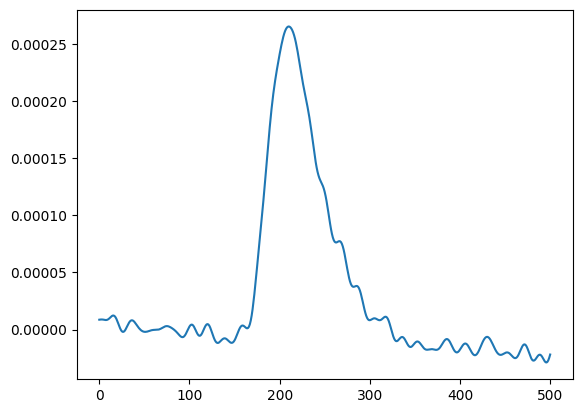

In [261]:
# Create epochs
# 300 Datenpunkte, da visuelle Potentiale eine 
tmin = -0.3
tmax = 0.7
baseline = (None, 0)
epochs = mne.Epochs(filtered_raw, 
                    events=events,
                   tmin=tmin,
                   tmax=tmax,
                   baseline=baseline,
                   preload=True) 
epochs.drop_bad()

# Extrahieren der Daten für alle Epochen
epoch_data = epochs.get_data()

# Ausgabe der Form des epoch_data-Arrays
print(epoch_data.shape)

epochs.plot()

    
plt.plot(epoch_data[0][0])
plt.show()

Zu sehen ist, dass 600ms ausreichen um ein gesamtes visuell evoziertes Potential zu segmentieren

#### Erstellen der Evozierten Segmente

Zunächst kann die Anzahl der Stimuli und die Anzahl der unterschiedlichen Stimuli bestimmt werden

In [238]:
def create_epoch_dict(epochs, raw):
    epoch_dict= []
    amount = epochs.shape[0]
    channels = epochs.shape[1]
    
    for i in range(channels-1):
        for j in range(amount):
            
            epoch_dict.append({'channel': raw.ch_names[i], 'nr': j, 'data': epochs[j][i]})
    
    return epoch_dict

epoch_dict = create_epoch_dict(epoch_data, filtered_raw)
print(len(epoch_dict))
normalized_dict = normalize_epochs(epoch_dict)

54810


In [240]:
# Berechne Standardabweichungen für alle Fenster
std_values = [np.std(window['data']) for window in normalized_dict]
# Finde das gewünschte Perzentil (z.B. 25. Perzentil) der Standardabweichungen
th = np.percentile(std_values, 95)
print(th)

cleared_epochs, deleted_epoch = clear_flatlines(normalized_dict, th)
print(len(cleared_epochs), len(deleted_epoch))

0.019165910477634367
2741 52069


In [242]:
final_epochs = []
no_peaks_2 = []



for epoch in cleared_epochs:
    if peak_above_threshold(epoch['data'], 0.5):
        final_epochs.append(epoch)
    else:
        no_peaks_2.append(epoch)
        
print(len(final_epochs), len(no_peaks_2))

1290 1451


In [244]:
with open("../files/epochs_files/final_epochs.pickle", 'wb') as f:
    pickle.dump(final_epochs, f)


epochs_flatlines = deleted_epochs + no_peaks_2
with open("../files/epochs_files/epochs_flatlines.pickle", 'wb') as f:
    pickle.dump(epochs_flatlines, f)

Nun kann die Kreuzkorrelationsmatrix gebildet werden
dazu muss die correlation.py Datei ausgeführt werden.


Die Erste Anwendugn wird mit den Segmentierten Fenstern durchgeführt

Nachdem die Korrelationsmatrix erstellt wurde, kann das clustern beginnen. Dazu sind im Projektordner 4 Clustermethoden zu finden:
- KMeans
- DBScan
- Hierachical Clustering
-Affinity Propagation

All diese Methoden arbeiten auch mit einer eigenen Art zur Ermittlung der optimalen Anzahl der Cluster:
- Gap Statistics
- Elbow Method
- Silhouette Score

#### KMeans

9223
0
0
1
2
3
4
5
6
7
8
9
1
0
1
2
3


Traceback (most recent call last):
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 935, in format_exception_as_a_whole
    self.get_records(etb, number_of_

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 935, in format_exception_as_a_whole
    self.get_records(etb, number_of_

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 935, in format_exception_as_a_whole
    self.get_records(etb, number_of_

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 935, in format_exception_as_a_whole
    self.get_records(etb, number_of_

Unexpected exception formatting exception. Falling back to standard exception
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 935, in format_exception_as_a_whole
    self.get_records(etb, number_of_

Unexpected exception formatting exception. Falling back to standard exception
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 935, in format_exception_as_a_whole
    self.get_records(etb, number_of_

Unexpected exception formatting exception. Falling back to standard exception
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1288, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1177, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1030, in structured_traceback
    formatted_exception = self.format_exception_as_a_whole(etype, evalue, etb, number_of_lines_of_context,
  File "/Users/kaanerbay/miniconda3/envs/main/lib/python3.9/site-packages/IPython/core/ultratb.py", line 935, in format_exception_as_a_whole
    self.get_records(etb, number_of_

Unexpected exception formatting exception. Falling back to standard exception
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
3
0
1
2
3
4
5
6
7
8
9
4
0
1
2
3
4
5
6
7
8
9
5
0
1
2
3
4
5
6
7
8
9
6
0
1
2
3
4
5
6
7
8
9
7
0
1
2
3
4
5
6
7
8
9
8
0
1
2
3
4
5
6
7
8
9


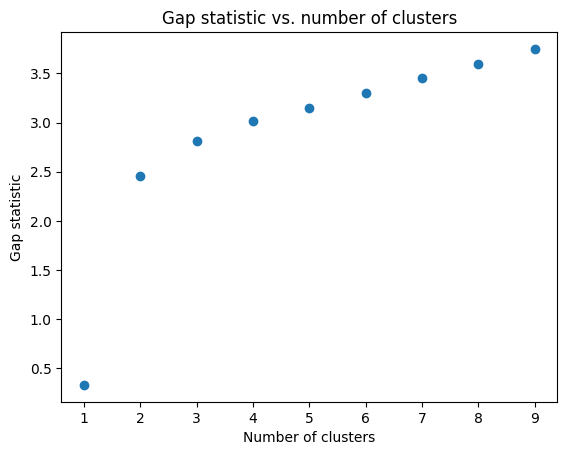

Optimal number of clusters: 9
1
2
3
4
5
6
7
8
9


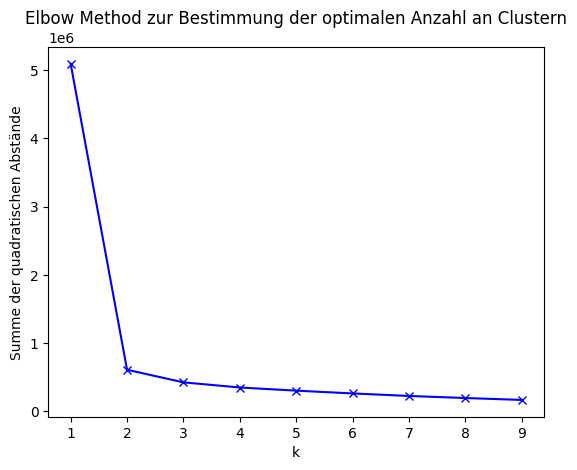

KeyboardInterrupt: Interrupted by user

In [65]:
# Find optimal number of clusters using Gap-Statistics method
def opt_num(X):
    """
    This function calculates and returns the optimal number of clusters
    using the gap statistic method.
    """
    # Initializations
    n_clusters = range(1, 10)
    gaps = np.zeros(len(n_clusters))
    stds = np.zeros(len(n_clusters))

    # Compute the gap statistic for each value of k
    for i, k in enumerate(n_clusters):
        # Fit the k-means model
        km = KMeans(n_clusters=k, n_init=10)
        print(i)
        km.fit(X)

        # Calculate within-cluster dispersion
        disp = km.inertia_

        # Generate reference data set and calculate its dispersion
        ref_disp = np.zeros(10)
        for j in range(10):
            print(j)
            # Generate random data set
            random_data = np.random.random_sample(size=X.shape)

            # Fit k-means to random data set
            km = KMeans(n_clusters=k, n_init=10)

            km.fit(random_data)

            # Calculate within-cluster dispersion
            ref_disp[j] = km.inertia_

        # Calculate gap statistic and standard deviation
        gaps[i] = np.mean(np.log(ref_disp)) - np.log(disp)
        stds[i] = np.sqrt(1 + 1 / 10) * np.std(np.log(ref_disp))

    # Calculate the optimal number of clusters
    opt_k = gaps.argmax() + 1

    # Plot the gap statistic
    plt.errorbar(n_clusters, gaps, yerr=stds, fmt='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Gap statistic')
    plt.title('Gap statistic vs. number of clusters')
    plt.show()

    return opt_k



def kmeans_cluster():
    # Abstandsmatrix
    cross_correlations = load_np_array_pickle('../files/correlation_files/correlation_compare.pickle')
    print(len(cross_correlations))
    distance_matrix = 1 - cross_correlations
    # Call the function and print the optimal number of clusters
    opt_k = opt_num(distance_matrix)
    print("Optimal number of clusters:", opt_k)
    # Berechne optimale Anzahl an Clustern mithilfe des Elbow-Methods
    sum_of_squared_distances = []
    K = range(1, 10)
    for k in K:
        print(k)
        km = KMeans(n_clusters=k, n_init=10)
        km = km.fit(distance_matrix)
        sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Summe der quadratischen Abstände')
    plt.title('Elbow Method zur Bestimmung der optimalen Anzahl an Clustern')
    plt.show()

    # Anwenden des k-Means-Algorithmus auf die Abstandsmatrix
    optimal_number_of_clusters = int(input("Wähle die optimale Anzahl an Clustern aus dem Elbow-Plot aus: "))
    kmeans = KMeans(n_clusters=optimal_number_of_clusters, n_init=10)

    kmeans.fit(distance_matrix)
    labels = kmeans.labels_
    print("Cluster-Zuordnungen: ", labels)
    with open("../files/cluster_files/kmeans_windows.pickle", 'wb') as f:
        pickle.dump(labels, f)

if __name__ == "__main__":
    kmeans_cluster()

#### DBSCAN

In [ ]:
def dbscan_cluster():
    # Abstandsmatrix
    cross_correlations = load_np_array_pickle('../files/correlation_files/correlation_compare.pickle')
    # Convert cross-cluster matrix to distance matrix
    dist_matrix = 1 - cross_correlations
    best_score = -1
    best_eps = 0
    best_min_samples = 0

    for eps in np.arange(0.1, 1.0, 0.1):
        print(eps)
        for min_samples in range(1, dist_matrix.shape[0]):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
            labels = dbscan.fit_predict(dist_matrix)

            # Check if number of clusters is greater than 1
            if len(set(labels)) > 1:
                score = silhouette_score(dist_matrix, labels, metric='precomputed')
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    # Re-run DBSCAN with best parameters
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='precomputed')
    labels = dbscan.fit_predict(dist_matrix)
    print("Optimal DBSCAN parameters: eps = {}, min_samples = {}".format(best_eps, best_min_samples))
    print("Cluster labels:", labels)
    with open("../files/cluster_files/dbscan.pickle", 'wb') as f:
        pickle.dump(labels, f)

if __name__ == "__main__":
    dbscan_cluster()

#### Hierachical Clustering

In [ ]:
def hierachical_cluster():
    # Abstandsmatrix
    cross_correlations = load_np_array_pickle('../../epochs_files/correlation_compare.pickle')
    distance_matrix = 1 - cross_correlations
    condensed_distance_matrix = squareform(distance_matrix)
    # Berechne den Hierarchischen Clustering
    Z = sch.linkage(condensed_distance_matrix, method='ward')

    # Plotte den Dendrogramm
    plt.title("Agglomerativer Hierarchischer Clustering")
    sch.dendrogram(Z, labels=np.arange(len(distance_matrix)))
    plt.show()

    # Bestimme die ideale Anzahl an Clustern
    last = Z[-10:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    plt.plot(idxs, last_rev)

    acceleration = np.diff(last, 2)  # 2nd Derivative of the distances
    acceleration_rev = acceleration[::-1]
    plt.plot(idxs[:-2] + 1, acceleration_rev)
    plt.show()
    k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
    print("Optimale Anzahl an Clustern: ", k)

    # Hierarchischer Cluster Algorithmus
    linked = linkage(condensed_distance_matrix, method='ward')
    # Clusterberechnung
    clusters = fcluster(linked, k, criterion='maxclust')
    print("Cluster-Zuordnung für jeden Datenpunkt:  \n", clusters)
    with open("../../files/cluster_files/hierachical.pickle", 'wb') as f:
         pickle.dump(clusters, f)

if __name__ == "__main__":
    hierachical_cluster()

#### Affinity Propagation

In [ ]:
def affinity_cluster():
    cross_correlations = load_np_array_pickle('../../epochs_files/correlation_compare.pickle')

    best_score = -1
    best_damping = 0

    for damping in np.arange(0.5, 1.0, 0.05):
        ap = AffinityPropagation(damping=damping)
        labels = ap.fit_predict(cross_correlations)

        # Check if number of clusters is greater than 1
        if len(set(labels)) > 1:
            score = silhouette_score(cross_correlations, labels)
            if score > best_score:
                best_score = score
                best_damping = damping

    # Re-run Affinity Propagation with best parameters
    ap = AffinityPropagation(damping=best_damping)
    labels = ap.fit_predict(cross_correlations)
    print("Optimal Affinity Propagation parameters: damping = {}".format(best_damping))
    print("Cluster labels:", labels)
    with open("../../files/cluster_files/ap.pickle", 'wb') as f:
        pickle.dump(labels, f)


if __name__ == "__main__":
    affinity_cluster()

Die Ergebnisse der Clusteranalyse kann sich mit dem Script cluster_results.py angeschaut werden


Das Ergebnis der Clusteranalyse hat gezeigt, dass die Segmentierungsmethode erhebliche mängel aufweist bei der Ermittlung der Spitze Werte der Reaktionsanteile im Signal.
Dies kann mit der 2. Methode umgangen werden


Um den Neuronalen Netz genug Trainingsdaten zur verfügung zu geben, müssen genug daten für folgende Klassen vorhanden sein:
- ERP
- Nicht ERP

Um nun Daten zu sammeln die keine ERPs beinhalten, können die Zeitabschnitte des EEGs genutzt werden, in denen "Ruhe" ist


[ 41  72 504 651 719]


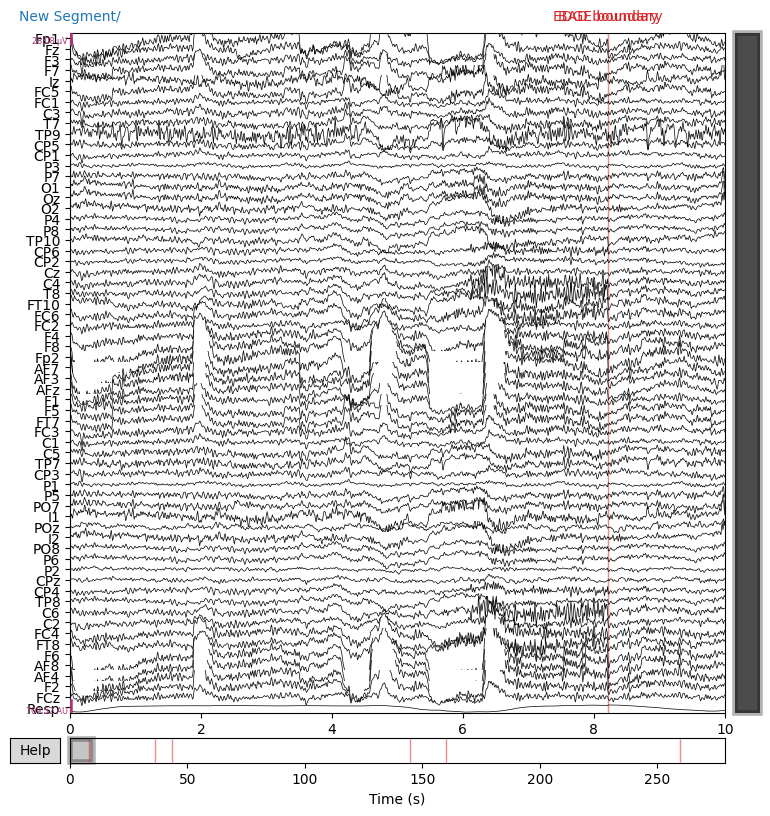

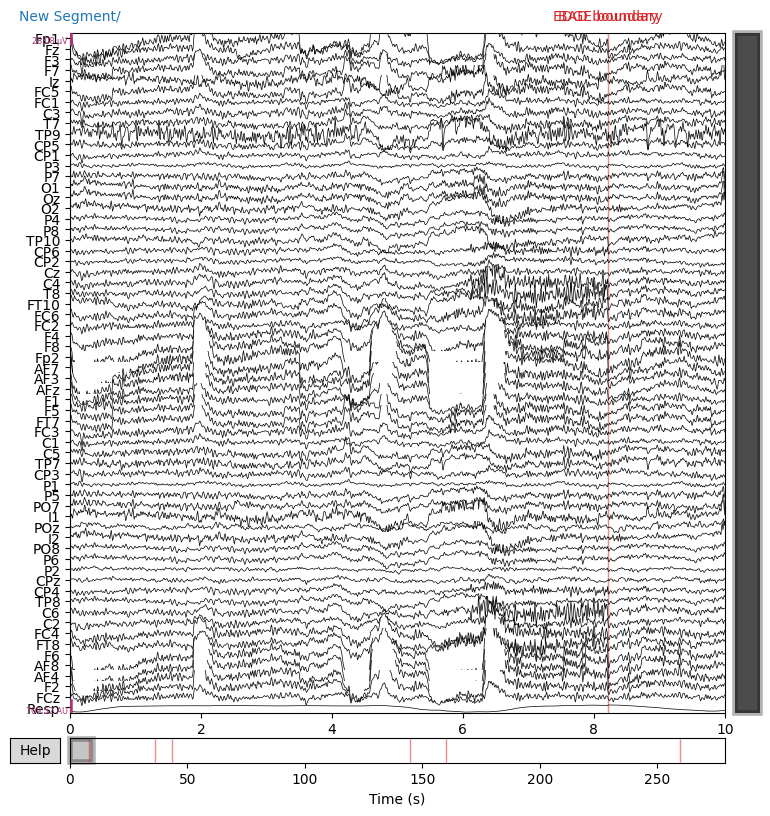

In [190]:
# Finden den Startzeitpunkt des ersten Events und den Endzeitpunkt des letzten Events
first_event_start = events[0][0] / raw.info['sfreq']
last_event_end = events[-1][0] / raw.info['sfreq']

buffer_time = 5  # Pufferzeit in Sekunden

# Extrahieren der Ruhedaten vor dem ersten Event und nach dem letzten Event
rest_data_before = filtered_raw.copy().crop(tmin=0, tmax=first_event_start - buffer_time)
rest_data_after = filtered_raw.copy().crop(tmin=last_event_end + buffer_time, tmax=None)
rest_data = rest_data_before

# Konvertiere die Event-Sample-Nummern in Zeit (Sekunden)


# Finde längere Pausen (>= 20 Sekunden) zwischen den Events
pause_indices = np.where(np.diff(event_times) >= 3*buffer_time)[0]
print(pause_indices)

for i in pause_indices:
    rest = filtered_raw.copy().crop(tmin = event_times[i] + buffer_time, tmax = event_times[i+1] - buffer_time)
    rest_data = mne.concatenate_raws([rest_data, rest])
rest_data = mne.concatenate_raws([rest_data, rest_data_after])

# Visualisierung der Ruhedaten (optional)
rest_data.plot(scalings='auto', duration=10, n_channels=len(rest_data.ch_names), show=True)


In [196]:
rest_windows = create_windows(0.333333, 400, rest_data.get_data()[:-1], 500)
print(len(rest_windows[0]))

523


In [202]:
rest_dict = create_window_dict(rest_windows, rest_data)
rest_normalized = normalize_epochs(rest_dict)
erp, rest_final = clear_flatlines(rest_normalized, 0.025)

In [208]:
print(len(rest_final), len(erp))

29901 3048


In [297]:
with open("../files/windows_files/rest_data.pickle", 'wb') as f:
    pickle.dump(rest_final, f)

#### Neuronales Modell ausprobieren

In [16]:
model = load_model('./NeuralNet/models/ffnn.h5')

In [17]:
batch_size = 512
prediction_list = []

# Anzahl der Batches berechnen
num_batches = int(np.ceil(len(normalized_windows_dict) / batch_size))

for i in range(num_batches):
    # Start- und Endindex für den aktuellen Batch extrahieren
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(normalized_windows_dict))

    # Aktuellen Batch aus den Daten extrahieren und die Dimension erweitern
    batch_data = [np.expand_dims(data['data'], axis=0) for data in normalized_windows_dict[start_idx:end_idx]]
    batch_data = np.concatenate(batch_data, axis=0)

    # Vorhersagen für den aktuellen Batch durchführen
    batch_preds = model.predict(batch_data)

    # Klassenlabels aus den Wahrscheinlichkeiten extrahieren und der Vorhersageliste hinzufügen
    batch_pred_labels = np.argmax(batch_preds, axis=1)
    prediction_list.extend(batch_pred_labels)




 1/16 [>.............................] - ETA: 0s

2023-03-28 17:48:50.219480: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 514us/step


16/16 [==============================] - 0s 471us/step


16/16 [==============================] - 0s 450us/step


16/16 [==============================] - 0s 460us/step


16/16 [==============================] - 0s 517us/step


16/16 [==============================] - 0s 604us/step


7/7 [==============================] - 0s 625us/step


In [18]:
count_ones = prediction_list.count(1)

In [19]:
print(count_ones)

18817


In [20]:
def get_time_at_index(time_range, index, data_length):
    start_time, end_time = time_range
    time_step = (end_time - start_time) / data_length

    return start_time + (index * time_step)


def is_within_buffer(existing_peaks, new_peak, buffer):
    for peak in existing_peaks:
        if peak['ch'] == new_peak['ch'] and abs(peak['time'] - new_peak['time']) <= buffer:
            return True
    return False

buffer = 1  # Puffer in Sekunden, passen Sie diesen Wert entsprechend an
peaks = []
peaks_data = []
for idx, data in enumerate(normalized_windows_dict):
    if prediction_list[idx] == 1:
        meta = {'time': get_time_at_index(data['time'], np.array(data['data']).argmax(), 300), 'ch': data['channel']}

        if not is_within_buffer(peaks, meta, buffer):
            peaks.append(meta)
            peaks_data.append(data['data'])
        else:
            for peak in peaks:
                if peak['ch'] == meta['ch'] and abs(peak['time'] - meta['time']) <= buffer:
                    if meta['time'] < peak['time']:
                        peak['time'] = meta['time']
                    break
        

7968


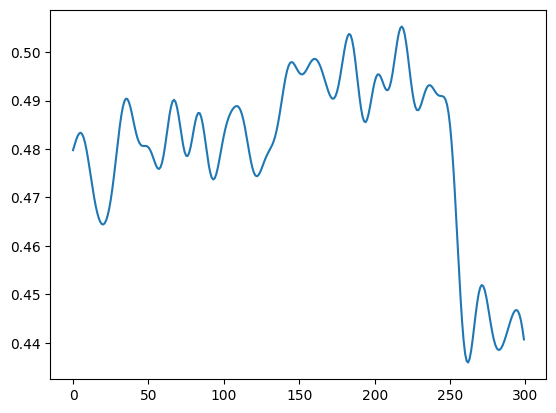

In [21]:
print(len(peaks))
plt.plot(peaks_data[1])
plt.show()

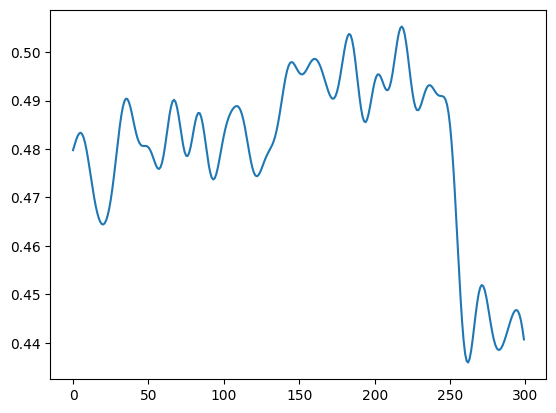

In [22]:
predicted_data = []
for i, data in enumerate(peaks):
    predicted_data.append({'time': data['time'], 'ch': data['ch'], 'data': peaks_data[i]})

plt.plot(predicted_data[1]['data'])
plt.show()
    
with open("../files/predicted_data.pickle", 'wb') as f:
    pickle.dump(predicted_data, f)

In [35]:
def filter_by_ch(data_list, ch_value):
    filtered_list = [obj for obj in data_list if obj['ch'] == ch_value]
    return filtered_list

Anscheinend sind nicht in allen Kanälen Peaks klassifiziert worden

In [49]:
matrix_names = []
for i, ch_names in enumerate(filtered_raw.ch_names):
    print(i, ch_names, len(filter_by_ch(predicted_data, ch_names)))
    if len(filter_by_ch(predicted_data, ch_names)) != 0:
           matrix_names.append(ch_names)


0 Fp1 362
1 Fz 229
2 F3 140
3 F7 282
4 Iz 109
5 FC5 281
6 FC1 21
7 C3 65
8 T7 63
9 TP9 138
10 CP5 34
11 CP1 3
12 P3 0
13 P7 15
14 O1 33
15 Oz 34
16 O2 100
17 P4 13
18 P8 14
19 TP10 140
20 CP6 12
21 CP2 5
22 Cz 9
23 C4 76
24 T8 86
25 FT10 154
26 FC6 198
27 FC2 93
28 F4 247
29 F8 360
30 Fp2 367
31 AF7 365
32 AF3 295
33 AFz 285
34 F1 224
35 F5 282
36 FT7 281
37 FC3 122
38 C1 17
39 C5 63
40 TP7 65
41 CP3 33
42 P1 0
43 P5 15
44 PO7 42
45 I1 108
46 POz 0
47 I2 94
48 PO8 12
49 P6 12
50 P2 2
51 CPz 1
52 CP4 12
53 TP8 34
54 C6 84
55 C2 42
56 FC4 225
57 FT8 198
58 F6 363
59 AF8 362
60 AF4 306
61 F2 246
62 FCz 95
63 Resp 0


In [82]:
matrix = np.array((63, 5000))

predicted_data = load_np_array_pickle('../files/predicted_data.pickle')


In [83]:
# Gruppieren Sie die Daten nach 'ch'-Werten.
grouped_data = defaultdict(list)
for data in predicted_data:
    grouped_data[data['ch']].append(data)



In [84]:
time_values = [data['time'] for data in predicted_data]
min_time = min(time_values)
max_time = max(time_values)
# Ranges erstellen
step = 0.1

ranges = []
current_time = min_time - (step/2)

while current_time <= max_time:
    lower_bound = round(current_time, 2)
    upper_bound = round(current_time + step, 2)
    time_range = (lower_bound, upper_bound)
    ranges.append(time_range)
    current_time += step
# Ergebnisse ausgeben
for r in ranges:
    print(r)
amount_cols = len(ranges)

matrix = np.zeros((len(filtered_raw.ch_names)-1, amount_cols))
print(matrix.shape)


(0.7, 0.8)
(0.8, 0.9)
(0.9, 1.0)
(1.0, 1.1)
(1.1, 1.2)
(1.2, 1.3)
(1.3, 1.4)
(1.4, 1.5)
(1.5, 1.6)
(1.6, 1.7)
(1.7, 1.8)
(1.8, 1.9)
(1.9, 2.0)
(2.0, 2.1)
(2.1, 2.2)
(2.2, 2.3)
(2.3, 2.4)
(2.4, 2.5)
(2.5, 2.6)
(2.6, 2.7)
(2.7, 2.8)
(2.8, 2.9)
(2.9, 3.0)
(3.0, 3.1)
(3.1, 3.2)
(3.2, 3.3)
(3.3, 3.4)
(3.4, 3.5)
(3.5, 3.6)
(3.6, 3.7)
(3.7, 3.8)
(3.8, 3.9)
(3.9, 4.0)
(4.0, 4.1)
(4.1, 4.2)
(4.2, 4.3)
(4.3, 4.4)
(4.4, 4.5)
(4.5, 4.6)
(4.6, 4.7)
(4.7, 4.8)
(4.8, 4.9)
(4.9, 5.0)
(5.0, 5.1)
(5.1, 5.2)
(5.2, 5.3)
(5.3, 5.4)
(5.4, 5.5)
(5.5, 5.6)
(5.6, 5.7)
(5.7, 5.8)
(5.8, 5.9)
(5.9, 6.0)
(6.0, 6.1)
(6.1, 6.2)
(6.2, 6.3)
(6.3, 6.4)
(6.4, 6.5)
(6.5, 6.6)
(6.6, 6.7)
(6.7, 6.8)
(6.8, 6.9)
(6.9, 7.0)
(7.0, 7.1)
(7.1, 7.2)
(7.2, 7.3)
(7.3, 7.4)
(7.4, 7.5)
(7.5, 7.6)
(7.6, 7.7)
(7.7, 7.8)
(7.8, 7.9)
(7.9, 8.0)
(8.0, 8.1)
(8.1, 8.2)
(8.2, 8.3)
(8.3, 8.4)
(8.4, 8.5)
(8.5, 8.6)
(8.6, 8.7)
(8.7, 8.8)
(8.8, 8.9)
(8.9, 9.0)
(9.0, 9.1)
(9.1, 9.2)
(9.2, 9.3)
(9.3, 9.4)
(9.4, 9.5)
(9.5, 9.6)
(9.6, 9.7)
(9.7, 9.8)

In [85]:
def find_range(ranges, x):
    for index, (lower_bound, upper_bound) in enumerate(ranges):
        if lower_bound <= x < upper_bound:
            return index
    return None



In [86]:
for i, ch in enumerate(filtered_raw.ch_names[:-1]):
    for el in grouped_data[ch]:
        range_index = find_range(ranges, el['time'])

        # Berechnen des Integrals mit der Trapezregel
        integral = np.trapz(el['data'])

        # Eintragen des Integrals in die Matrix
        matrix[i][range_index] = integral
        
        
np.set_printoptions(threshold=sys.maxsize, linewidth=200, suppress=True)

print(matrix[:, 10:20])

[[  0.           0.         159.35796024   0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.         149.25238068   0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.         149.76624984   0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.         149.7125564    0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.           

In [87]:
for j in range(matrix.shape[1]):
    num_nonzero = np.count_nonzero(matrix[:,j])
    print(f"Spalte {j}: {num_nonzero} Werte ungleich Null")

Spalte 0: 1 Werte ungleich Null
Spalte 1: 0 Werte ungleich Null
Spalte 2: 0 Werte ungleich Null
Spalte 3: 0 Werte ungleich Null
Spalte 4: 0 Werte ungleich Null
Spalte 5: 0 Werte ungleich Null
Spalte 6: 0 Werte ungleich Null
Spalte 7: 0 Werte ungleich Null
Spalte 8: 0 Werte ungleich Null
Spalte 9: 0 Werte ungleich Null
Spalte 10: 0 Werte ungleich Null
Spalte 11: 0 Werte ungleich Null
Spalte 12: 18 Werte ungleich Null
Spalte 13: 2 Werte ungleich Null
Spalte 14: 0 Werte ungleich Null
Spalte 15: 0 Werte ungleich Null
Spalte 16: 0 Werte ungleich Null
Spalte 17: 0 Werte ungleich Null
Spalte 18: 0 Werte ungleich Null
Spalte 19: 0 Werte ungleich Null
Spalte 20: 0 Werte ungleich Null
Spalte 21: 0 Werte ungleich Null
Spalte 22: 0 Werte ungleich Null
Spalte 23: 0 Werte ungleich Null
Spalte 24: 0 Werte ungleich Null
Spalte 25: 2 Werte ungleich Null
Spalte 26: 0 Werte ungleich Null
Spalte 27: 2 Werte ungleich Null
Spalte 28: 0 Werte ungleich Null
Spalte 29: 0 Werte ungleich Null
Spalte 30: 0 Werte 

In [88]:
# Index der Spalten, die entfernt werden müssen
cols_to_remove = []

# Schleife über alle Spalten des Arrays
for j in range(matrix.shape[1]):
    # Überprüfen, ob alle Elemente in der aktuellen Spalte gleich Null sind
    if np.count_nonzero(matrix[:,j]) == 0:
        cols_to_remove.append(j)

# Spalten entfernen und Indexe in ranges entfernen
matrix = np.delete(matrix, cols_to_remove, axis=1)
ranges = [ranges[i] for i in range(len(ranges)) if i not in cols_to_remove]

final_matrix = np.where(matrix ==0, 0, matrix)
print(final_matrix.shape)

(63, 1548)


(63, 63)


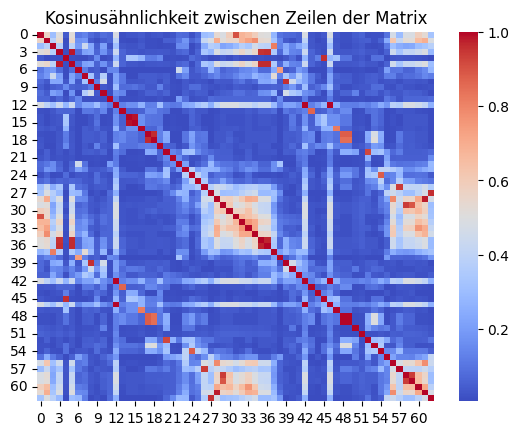

In [89]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
# Berechnen Sie die Kosinusähnlichkeit für die Zeilen der Matrix
similarity_matrix = cosine_similarity(final_matrix)
print(similarity_matrix.shape)
# Erstellen Sie eine Heatmap der Kosinusähnlichkeitsmatrix
sns.heatmap(similarity_matrix, cmap="coolwarm")

plt.title("Kosinusähnlichkeit zwischen Zeilen der Matrix")
plt.show()

In [103]:
# Berechnen Sie die Distanzmatrix (1 - Kosinusähnlichkeit)
distance_matrix = 1 - similarity_matrix
print(distance_matrix.shape)
# Führen Sie hierarchisches Clustering durch
clusters = linkage(distance_matrix, method='complete')
print(clusters.shape)

(63, 63)
(62, 4)


[ 3  6 11  1 23  1 29 16 18 32 19 35 10 31 22 22 21 14 14 33 24 37 30 27 25 26 13 12  4  2  9  3  7  8  6  1  1 11 29 18 20 17 10 31 34 23 10 21 14 14 38 36 24 15 25 28  5 13  2  2  8  4 12]


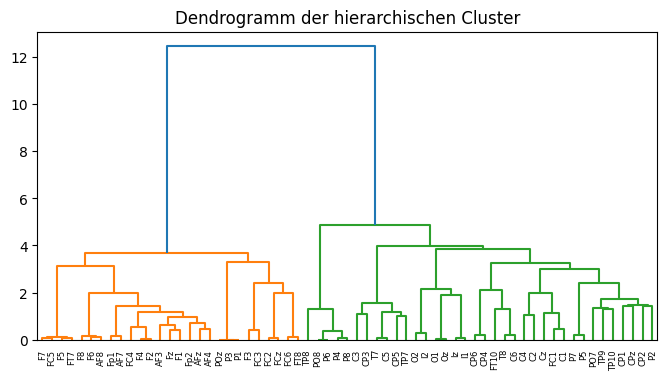

In [124]:
from scipy.cluster.hierarchy import linkage, dendrogram
# Zeichnen Sie das Dendrogramm
plt.figure(figsize=(8, 4))
dendrogram(clusters, labels=filtered_raw.ch_names[:-1], leaf_rotation=90)
plt.title("Dendrogramm der hierarchischen Cluster")
# Schwellenwert für Clusterbildung festlegen und Clusterzuordnungen abrufen
threshold = 0.5  # Schwellenwert anpassen, um die Anzahl der Cluster zu steuern
cluster_assignments = fcluster(clusters, threshold, criterion='distance')



print((cluster_assignments))


In [186]:
# Erstelle ein Dictionary, um Cluster-IDs und zugehörige Labels zu speichern
cluster_dict = defaultdict(list)

# Ordne die Labels ihren entsprechenden Clustern zu
for label, cluster_id in zip(filtered_raw.ch_names[:-1], cluster_assignments):
    cluster_dict[cluster_id].append(label)
ch_groups = []
# Ausgabe der gruppierten Cluster und ihrer Labels
for cluster_id, labels in cluster_dict.items():
    print(f"Cluster {cluster_id}:")
    print(labels)
    ch_groups.append(labels)

Cluster 3:
['Fp1', 'AF7']
Cluster 6:
['Fz', 'F1']
Cluster 11:
['F3', 'FC3']
Cluster 1:
['F7', 'FC5', 'F5', 'FT7']
Cluster 23:
['Iz', 'I1']
Cluster 29:
['FC1', 'C1']
Cluster 16:
['C3']
Cluster 18:
['T7', 'C5']
Cluster 32:
['TP9']
Cluster 19:
['CP5']
Cluster 35:
['CP1']
Cluster 10:
['P3', 'P1', 'POz']
Cluster 31:
['P7', 'P5']
Cluster 22:
['O1', 'Oz']
Cluster 21:
['O2', 'I2']
Cluster 14:
['P4', 'P8', 'PO8', 'P6']
Cluster 33:
['TP10']
Cluster 24:
['CP6', 'CP4']
Cluster 37:
['CP2']
Cluster 30:
['Cz']
Cluster 27:
['C4']
Cluster 25:
['T8', 'C6']
Cluster 26:
['FT10']
Cluster 13:
['FC6', 'FT8']
Cluster 12:
['FC2', 'FCz']
Cluster 4:
['F4', 'F2']
Cluster 2:
['F8', 'F6', 'AF8']
Cluster 9:
['Fp2']
Cluster 7:
['AF3']
Cluster 8:
['AFz', 'AF4']
Cluster 20:
['TP7']
Cluster 17:
['CP3']
Cluster 34:
['PO7']
Cluster 38:
['P2']
Cluster 36:
['CPz']
Cluster 15:
['TP8']
Cluster 28:
['C2']
Cluster 5:
['FC4']


['Fp1', 'Fz', 'F3', 'F7', 'Iz', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'I1', 'POz', 'I2', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'FCz', 'Resp']


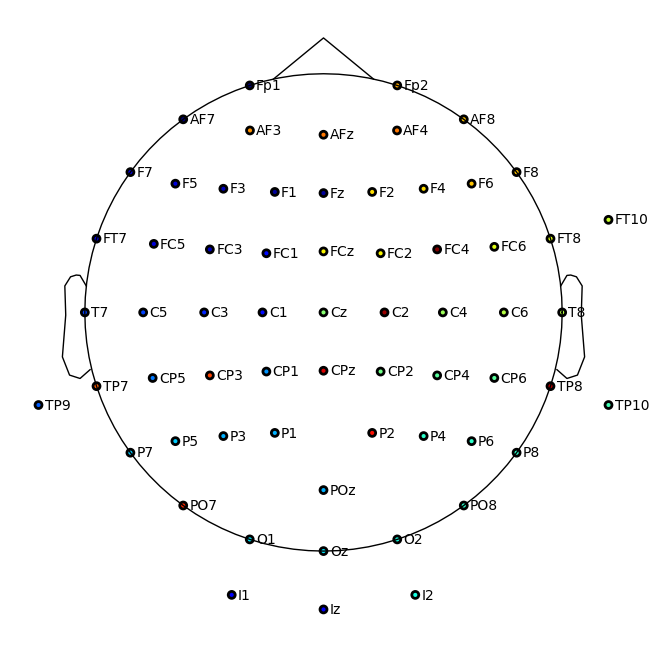

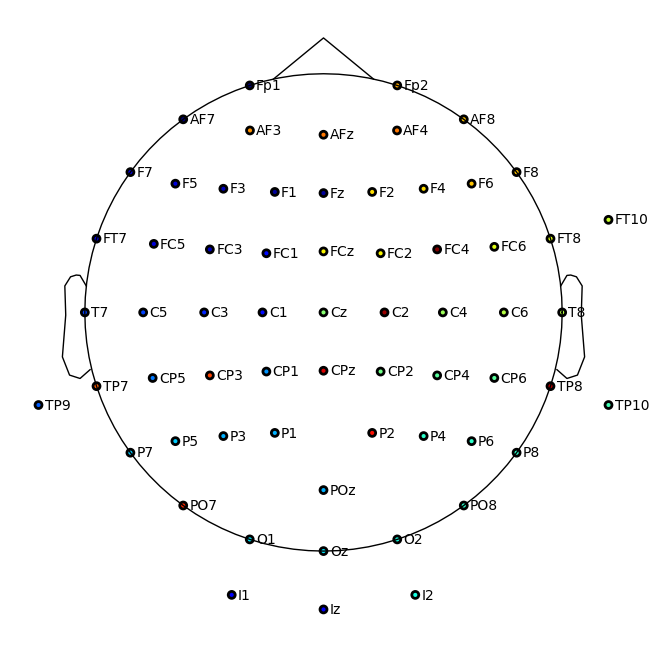

In [188]:
ch_index = []

for ch in ch_groups:
    el_index = []
    for el in ch:
        el_index.append(raw.ch_names.index(el))
    ch_index.append(el_index)
    
print(raw.ch_names)
mne.viz.plot_sensors(raw.info, show_names=True, ch_groups=ch_index)

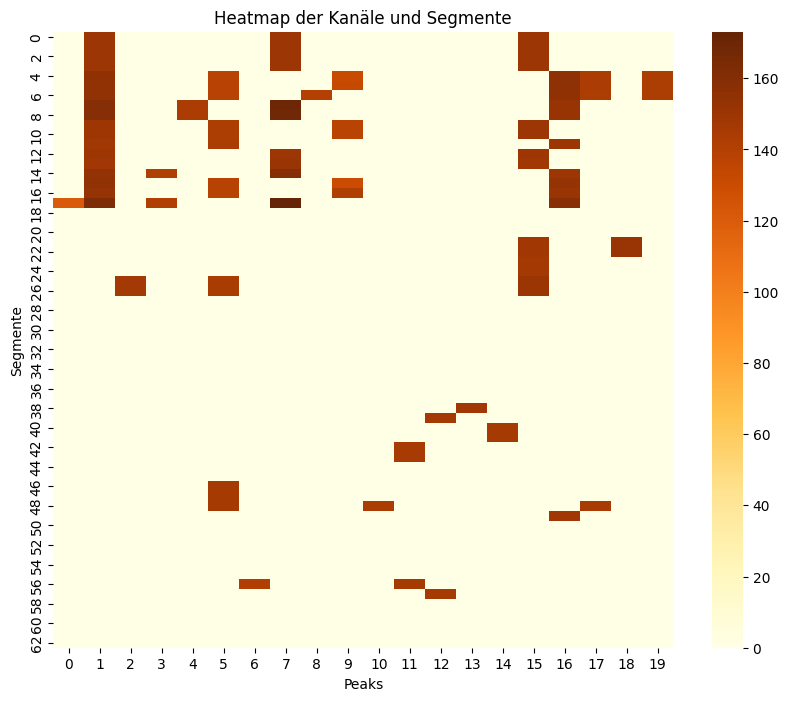

In [195]:
# Sortiere die Matrix entsprechend der Clusterzuordnung
sorted_indices = np.argsort(cluster_assignments)
sorted_matrix = matrix[sorted_indices]

subset_matrix = sorted_matrix[:, :20]

# Erstelle die Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(subset_matrix, cmap="YlOrBr")
plt.xlabel("Peaks")
plt.ylabel("Segmente")
plt.title("Heatmap der Kanäle und Segmente")
plt.show()